## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [ ]:
print(dat['run'].shape)

(7018, 1)


<ipython-input-8-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


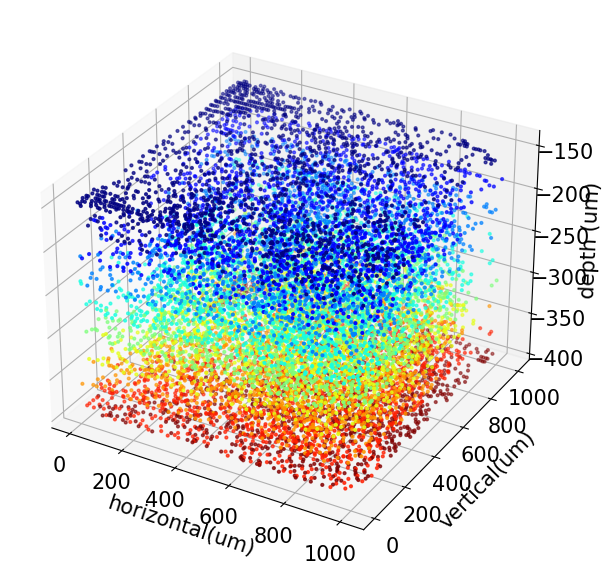

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

copmute R^2 for different depths, use colours as an indication for accuracy
use slices of depths and divide it into four qudrants

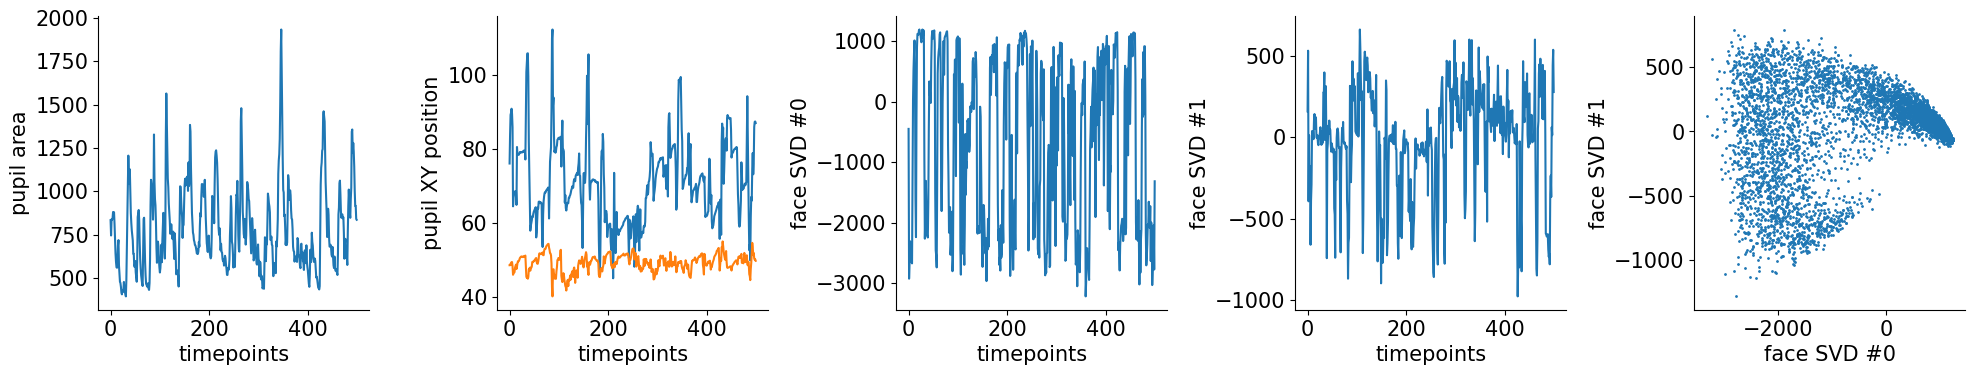

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

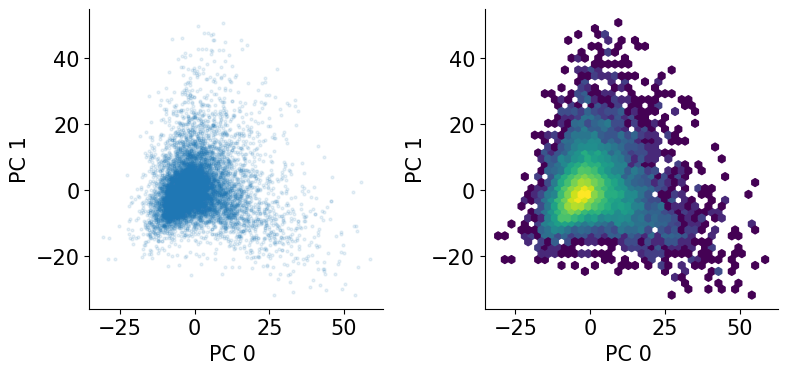

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

0.0 57.55417351414499 3.9668140969962598


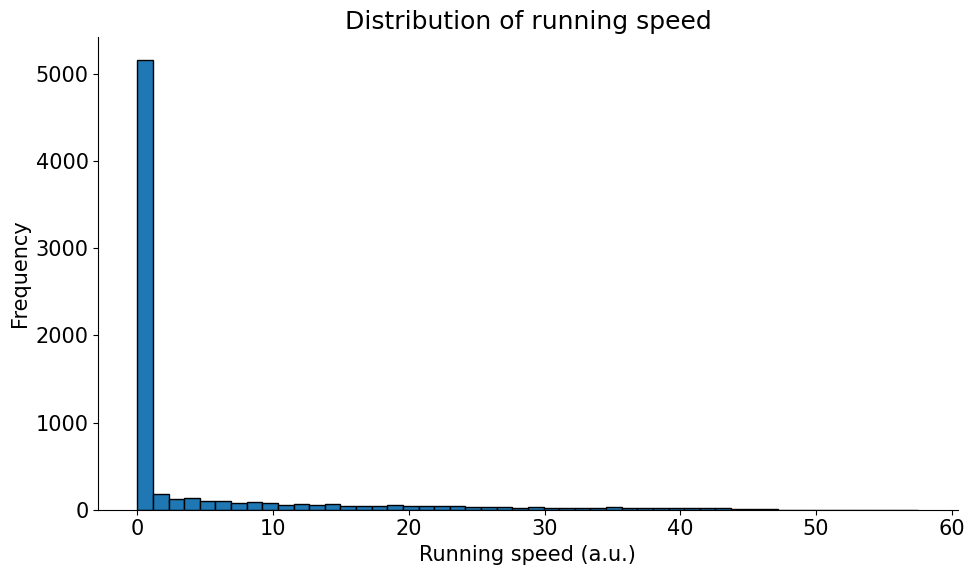

In [ ]:
run_data = dat['run']

min_speed = np.min(run_data)
max_speed = np.max(run_data)
mean_speed = np.mean(run_data)
median_speed = np.median(run_data)
std_speed = np.std(run_data)

plt.figure(figsize=(10, 6))
plt.hist(run_data, bins=50, edgecolor='black')
plt.title('Distribution of running speed')
plt.xlabel('Running speed (a.u.)')
plt.ylabel('Frequency')

print(min_speed, max_speed, mean_speed)

In [ ]:
X = dat['sresp'].T
y= dat['run']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 23.59
R-squared: 0.69


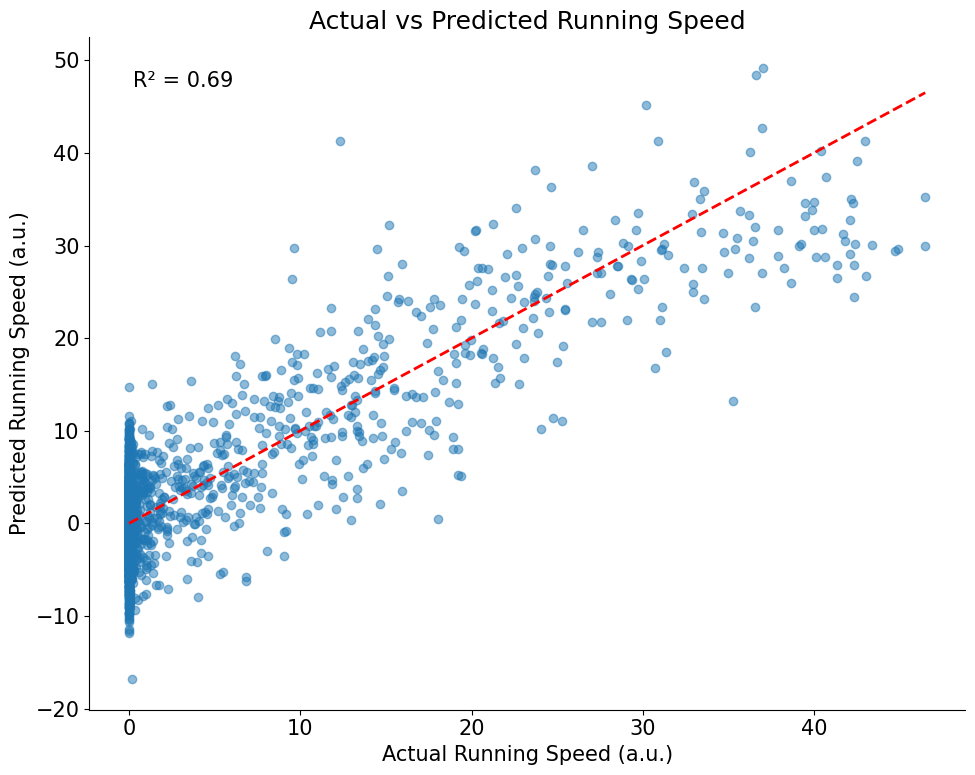

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Running Speed (a.u.)')
plt.ylabel('Predicted Running Speed (a.u.)')
plt.title('Actual vs Predicted Running Speed')

# Add text for R-squared value
r2 = model.score(X_test, y_test)
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.tight_layout()
plt.show()

Shape of X: (7018, 200)
Shape of y: (7018, 1)
Mean Squared Error: 10.80
R-squared: 0.86


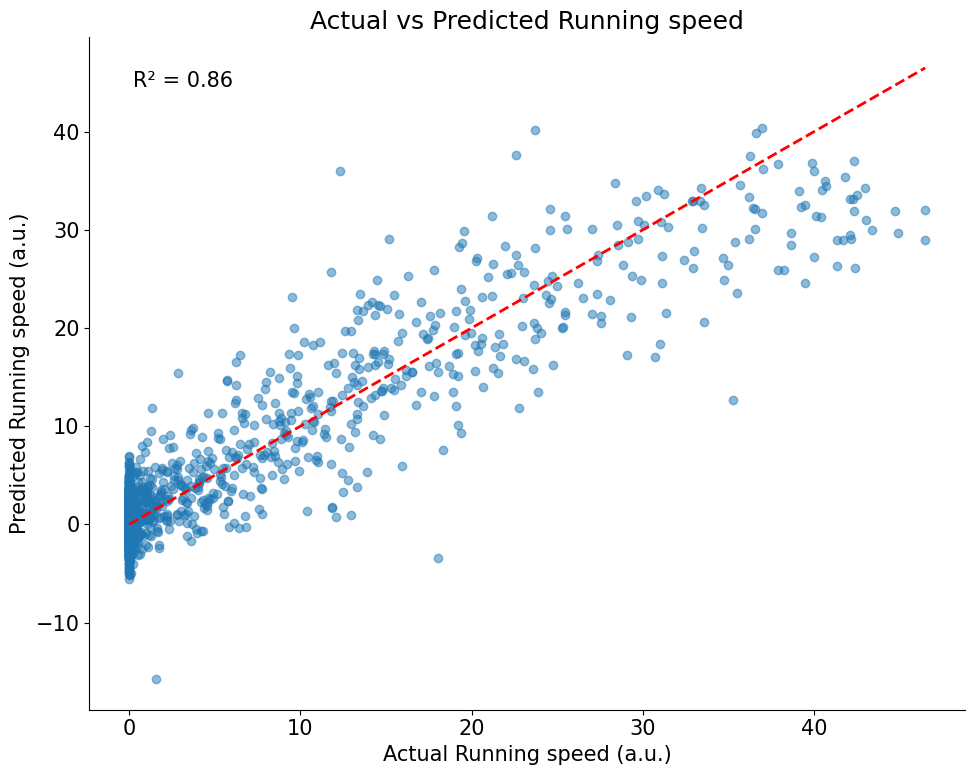

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Normalize and reduce dimensions
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z.T)  # Ensure transposing to match the number of samples with y

# Extract the target variable
y = dat['run']

# Check the shapes to ensure consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Running speed (a.u.)')
plt.ylabel('Predicted Running speed (a.u.)')
plt.title('Actual vs Predicted Running speed')

# Add text for R-squared value
r2 = model.score(X_test, y_test)
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Prepare data
X = dat['sresp'].T  # (timebins, neurons)
y = dat['run']

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
print(X.shape)
print(y.shape)

(7018, 11983)
(7018, 1)


normalise data using z-score

1. remove normalization, and normalize with z scores instead. and try to keep X shape as it is
2. layers- 11983 -> approx 80 ->  app 20, 1

1. use dimensionality reduction to reduce 11983 to 100 using PCA
2. Now create NN using 100 neurones (100->50->1)

In [ ]:
# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initialize the model
model = NeuralNet(X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46, 1, 1])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 52.9586
Epoch [20/100], Loss: 66.6596
Epoch [30/100], Loss: 10.9807
Epoch [40/100], Loss: 64.7478
Epoch [50/100], Loss: 106.6522
Epoch [60/100], Loss: 55.2086
Epoch [70/100], Loss: 119.4757
Epoch [80/100], Loss: 106.6497
Epoch [90/100], Loss: 84.8445
Epoch [100/100], Loss: 20.1618


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

print(f"Neural Network - Mean Squared Error: {mse}")
print(f"Neural Network - R-squared Score: {r2}")

Neural Network - Mean Squared Error: 74.99007760845586
Neural Network - R-squared Score: 0.017349394791022488


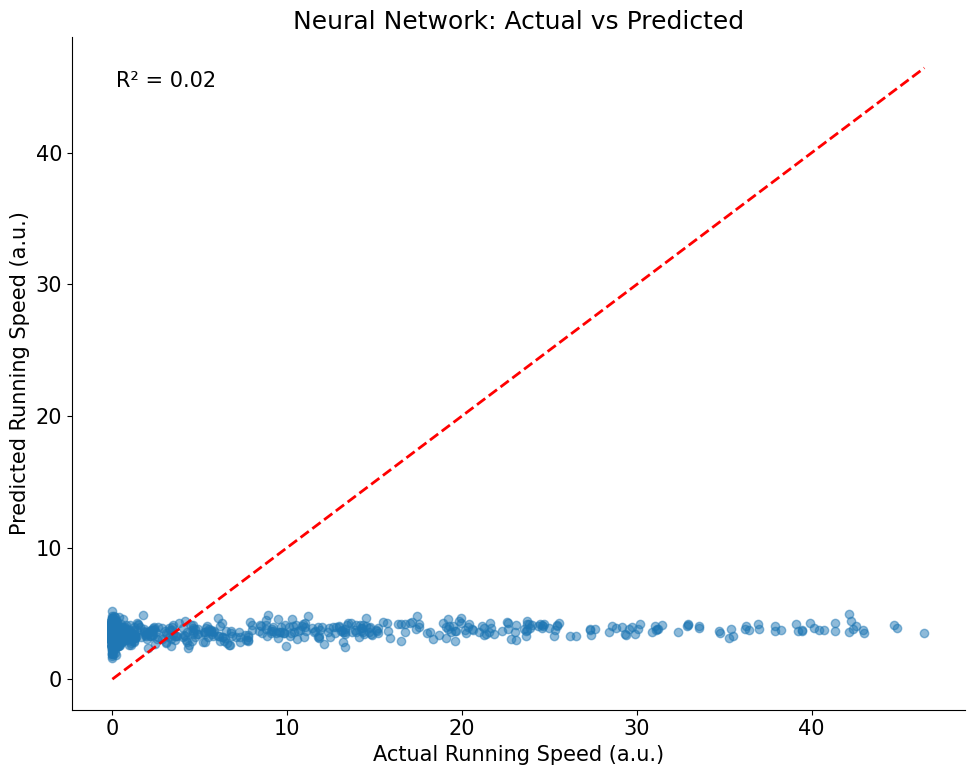

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Running Speed (a.u.)')
plt.ylabel('Predicted Running Speed (a.u.)')
plt.title('Neural Network: Actual vs Predicted')
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()


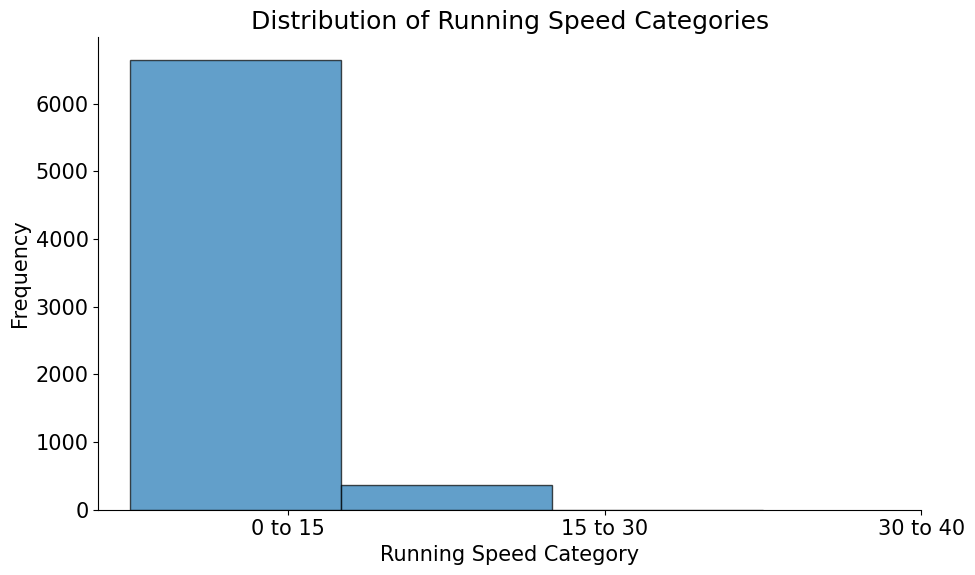

Category Counts: {'0 to x': 6647, 'x to y': 370, 'y to z': 1}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def categorize_running_speeds(run_data, x=15, y=30, z=40):
    """
    Categorizes running speeds into three groups: 0 to x, x to y, and y to z.

    Parameters:
        run_data (np.ndarray): Array of running speeds.
        x (float): First threshold for categorization.
        y (float): Second threshold for categorization.
        z (float): Third threshold for categorization.

    Returns:
        np.ndarray: Array of categorized speeds.
        dict: Dictionary with count of each category.
    """
    # Categorize the running speeds
    categories = np.digitize(run_data, bins=[x, y, z])

    # Map numerical categories to labels for better understanding
    category_labels = np.array(['0 to x', 'x to y', 'y to z'])
    categorized_speeds = category_labels[categories]

    # Count the number of instances in each category
    unique, counts = np.unique(categorized_speeds, return_counts=True)
    category_counts = dict(zip(unique, counts))

    return categorized_speeds, category_counts

# Example usage
run_data = dat['run']  # Replace this with the actual run data
categorized_speeds, category_counts = categorize_running_speeds(run_data, x=25, y=50, z=75)

# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
plt.hist(categorized_speeds, bins=3, edgecolor='black', alpha=0.7)
plt.title('Distribution of Running Speed Categories')
plt.xlabel('Running Speed Category')
plt.ylabel('Frequency')
plt.xticks([0.5, 1.5, 2.5], ['0 to 15', '15 to 30', '30 to 40'])
plt.tight_layout()
plt.show()

# Print category counts
print("Category Counts:", category_counts)


Shape of X: (7018, 200)
Shape of y: (7018, 1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46, 1, 1])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 142.5394
Epoch [20/100], Loss: 36.9643
Epoch [30/100], Loss: 51.2049
Epoch [40/100], Loss: 41.4900
Epoch [50/100], Loss: 128.3778
Epoch [60/100], Loss: 100.5453
Epoch [70/100], Loss: 81.1474
Epoch [80/100], Loss: 51.1715
Epoch [90/100], Loss: 226.1463
Epoch [100/100], Loss: 173.5181
Neural Network - Mean Squared Error: 74.2759
Neural Network - R-squared Score: 0.0267


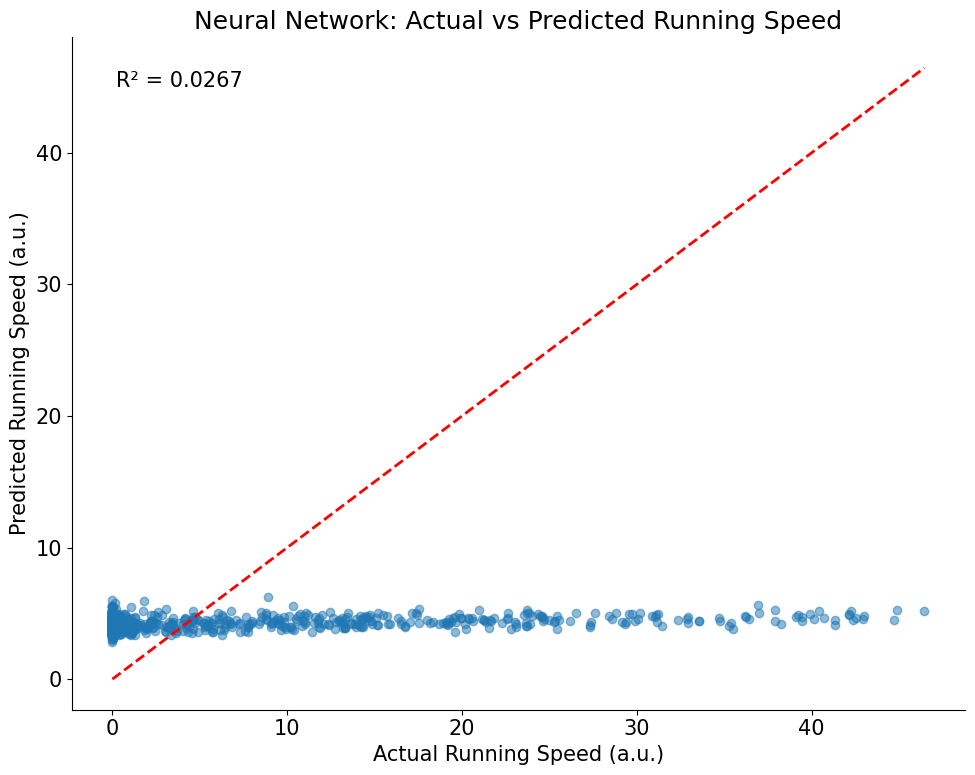

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Normalize and reduce dimensions
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z.T)  # Ensure transposing to match the number of samples with y

# Extract the target variable
y = dat['run']

# Check the shapes to ensure consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)  # First hidden layer with 50 neurons
        self.fc2 = nn.Linear(50, 20)  # Second hidden layer with 20 neurons
        self.fc3 = nn.Linear(20, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = NeuralNet(X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

print(f"Neural Network - Mean Squared Error: {mse:.4f}")
print(f"Neural Network - R-squared Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Running Speed (a.u.)')
plt.ylabel('Predicted Running Speed (a.u.)')
plt.title('Neural Network: Actual vs Predicted Running Speed')
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()


Shape of X: (7018, 200)
Shape of y: (7018, 1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46, 1, 1])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 172107.6562
Epoch [20/100], Loss: 123176.1172
Epoch [30/100], Loss: 163472.0938
Epoch [40/100], Loss: 111635.5547
Epoch [50/100], Loss: 179312.6094
Epoch [60/100], Loss: 129759.3516
Epoch [70/100], Loss: 173589.0781
Epoch [80/100], Loss: 160462.2188
Epoch [90/100], Loss: 113324.1016
Epoch [100/100], Loss: 119115.5078
Neural Network - Mean Squared Error: 138536.7095
Neural Network - R-squared Score: -0.0231


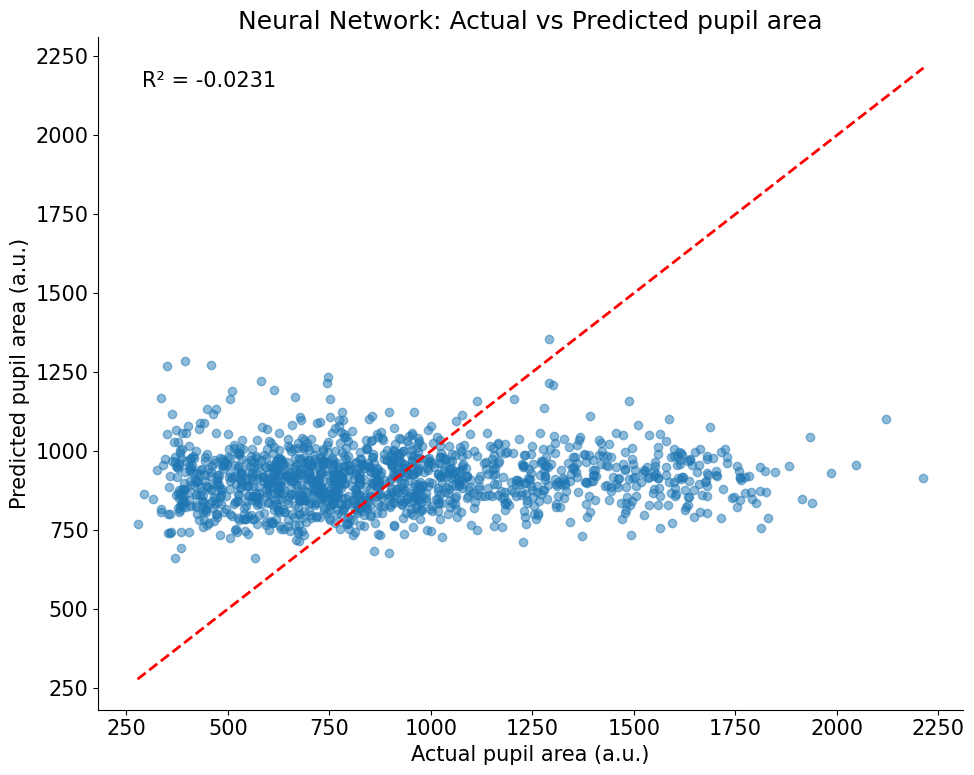

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Normalize and reduce dimensions
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z.T)  # Ensure transposing to match the number of samples with y

# Extract the target variable
y = dat['pupilArea']

# Check the shapes to ensure consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)  # First hidden layer with 50 neurons
        self.fc2 = nn.Linear(50, 20)  # Second hidden layer with 20 neurons
        self.fc3 = nn.Linear(20, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = NeuralNet(X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

print(f"Neural Network - Mean Squared Error: {mse:.4f}")
print(f"Neural Network - R-squared Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pupil area (a.u.)')
plt.ylabel('Predicted pupil area (a.u.)')
plt.title('Neural Network: Actual vs Predicted pupil area')
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()


NameError: name 'X_pca' is not defined

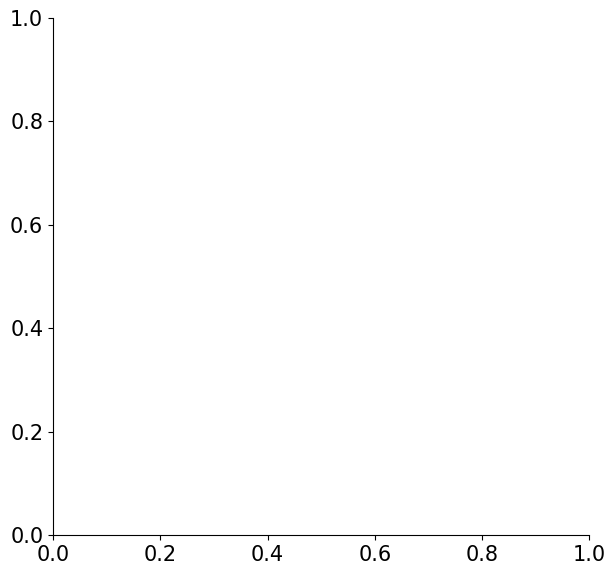

In [ ]:
# Visualize the relationship between the first few principal components and the running speed
plt.figure(figsize=(12, 6))

# First principal component vs running speed
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], y, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Running Speed (a.u.)')
plt.title('First Principal Component vs Running Speed')

# Second principal component vs running speed
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 1], y, alpha=0.5)
plt.xlabel('Second Principal Component')
plt.ylabel('Running Speed (a.u.)')
plt.title('Second Principal Component vs Running Speed')

plt.tight_layout()
plt.show()


**1. GLM FOR PUPIL AREA**

In [ ]:
X = dat['sresp'].T
y= dat['pupilArea']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual pupil area (a.u.)')
plt.ylabel('Predicted pupil area (a.u.)')
plt.title('Actual vs Predicted Pupil area')

# Add text for R-squared value
r2 = model.score(X_test, y_test)
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.tight_layout()
plt.show()

# **1B. GLM FOR PUPIL AREA WITH PCA**

Shape of X: (7018, 200)
Shape of y: (7018, 1)
Mean Squared Error: 16548.14
R-squared: 0.88


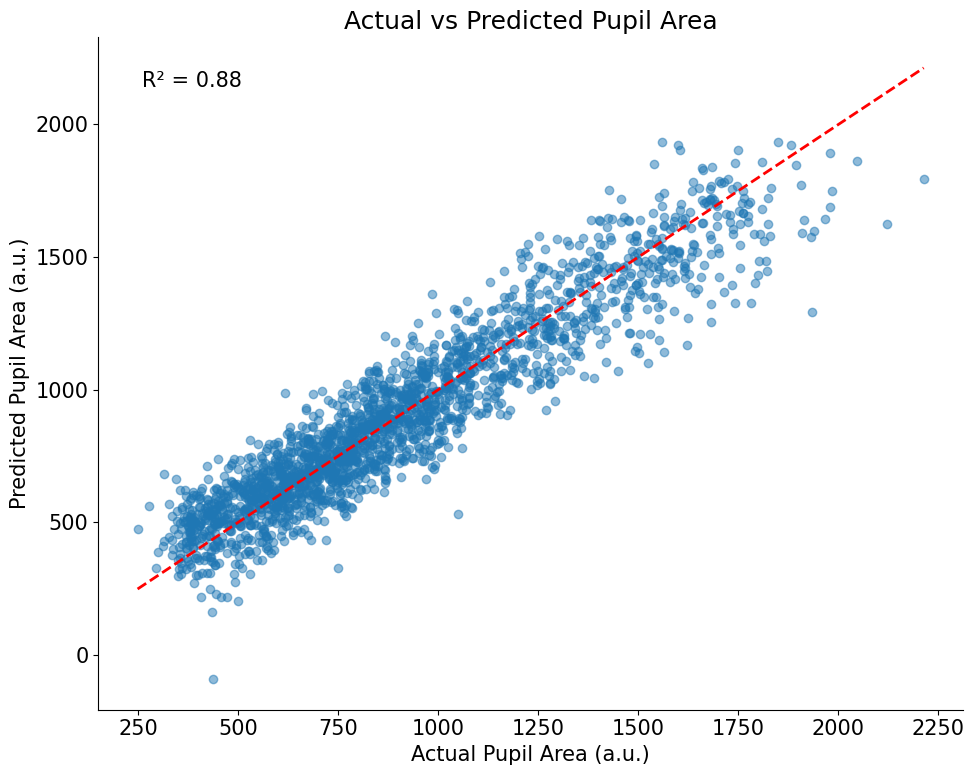

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Normalize and reduce dimensions
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z.T)  # Ensure transposing to match the number of samples with y

# Extract the target variable
y = dat['pupilArea']

# Check the shapes to ensure consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Pupil Area (a.u.)')
plt.ylabel('Predicted Pupil Area (a.u.)')
plt.title('Actual vs Predicted Pupil Area')

# Add text for R-squared value
r2 = model.score(X_test, y_test)
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.tight_layout()
plt.show()


**2. L2 RIDGE PENALTY**

Mean Squared Error: 23539.46
R-squared: 0.83


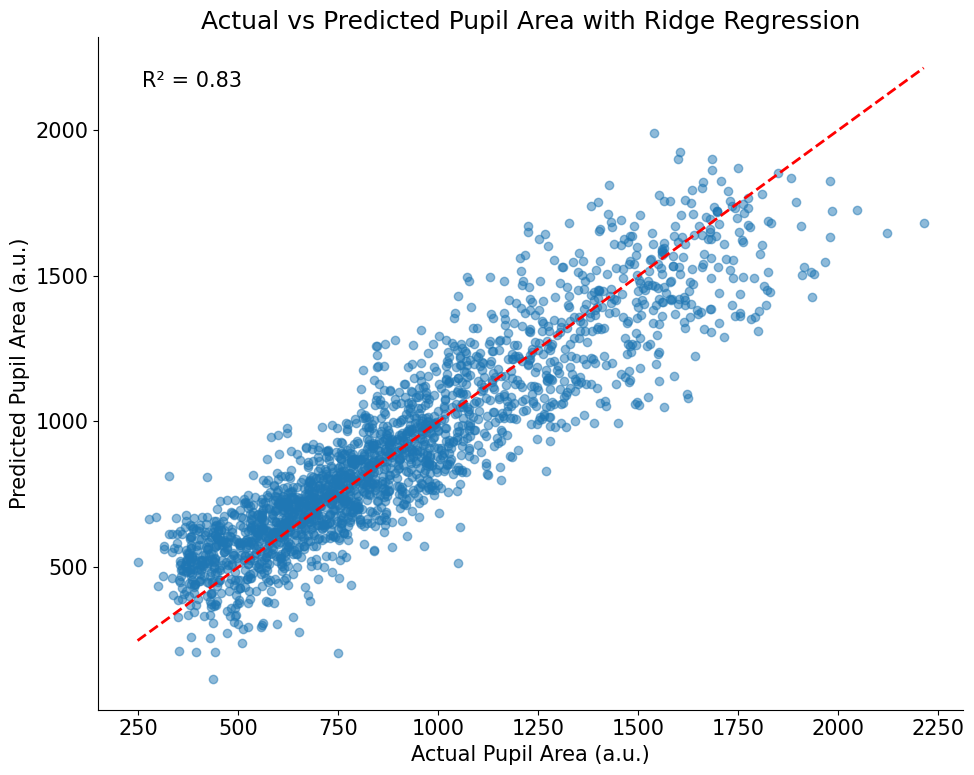

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the neural response data and the target variable
X = dat['sresp'].T  # Transpose to get timebins x neurons
y = dat['pupilArea']

# Standardize the neural response data using z-scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Train a Ridge regression model (L2 penalty)
alpha = 1.0  # Regularization strength
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = np.mean((y_pred - y_test) ** 2)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Pupil Area (a.u.)')
plt.ylabel('Predicted Pupil Area (a.u.)')
plt.title('Actual vs Predicted Pupil Area with Ridge Regression')

# Add text for R-squared value
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()


In [ ]:
# Inspect the depth values
depth_values = dat['xyz'][2, :]
print(f"Min depth value: {depth_values.min()}")
print(f"Max depth value: {depth_values.max()}")
print(f"Depth values distribution:\n{np.histogram(depth_values, bins=10)}")


Min depth value: -390.0
Max depth value: -150.0
Depth values distribution:
(array([1386, 1440, 1418, 1471,    0, 1415, 1321, 1218, 1183, 1131]), array([-390., -366., -342., -318., -294., -270., -246., -222., -198.,
       -174., -150.]))


In [ ]:
print(f"Shape of dat['sresp']: {dat['sresp'].shape}")
print(f"Shape of dat['xyz']: {dat['xyz'].shape}")
print(f"Shape of dat['pupilArea']: {dat['pupilArea'].shape}")


Shape of dat['sresp']: (11983, 7018)
Shape of dat['xyz']: (3, 11983)
Shape of dat['pupilArea']: (7018, 1)


Processing depth bin: -390 - -310
Number of neurons in this bin: 4244
Shape after scaling: (7018, 4244)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -390 - -310, R-squared: 0.81
Processing depth bin: -310 - -230
Number of neurons in this bin: 4207
Shape after scaling: (7018, 4207)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -310 - -230, R-squared: 0.80
Processing depth bin: -230 - -150
Number of neurons in this bin: 2401
Shape after scaling: (7018, 2401)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -230 - -150, R-squared: 0.71


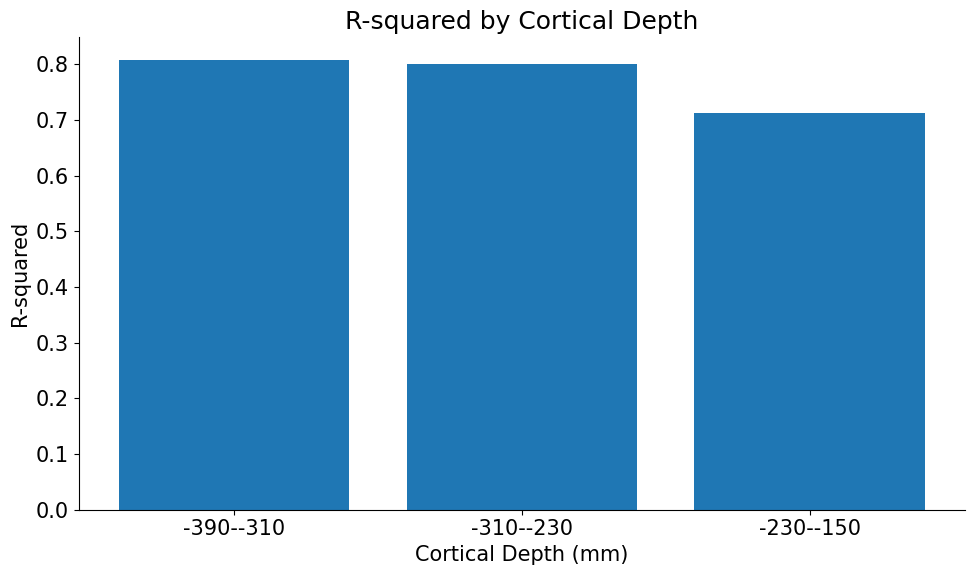

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define cortical depth bins (adjusted to range -390 to -150 mm)
depth_bins = [-390, -310, -230, -150]  # Using three bins

# Extract the target variable
y = dat['pupilArea']

# List to store R² scores for each depth segment
depth_r2_scores = []

# Iterate over cortical depth bins
for i in range(len(depth_bins) - 1):
    print(f"Processing depth bin: {depth_bins[i]} - {depth_bins[i+1]}")

    # Segment neurons by depth
    depth_mask = (dat['xyz'][2, :] >= depth_bins[i]) & (dat['xyz'][2, :] < depth_bins[i + 1])
    X_depth = dat['sresp'][depth_mask, :].T  # Transpose to get timebins x neurons

    print(f"Number of neurons in this bin: {X_depth.shape[1]}")

    if X_depth.shape[1] == 0:
        depth_r2_scores.append(np.nan)
        continue  # Skip if no neurons fall into this depth bin

    # Standardize the neural response data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_depth)

    print(f"Shape after scaling: {X_scaled.shape}")

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Shape after PCA: {X_pca.shape}")

    # Filter y to match the timebins in X
    y_filtered = y[:X_pca.shape[0], :]  # Ensure y has the same number of samples as X

    print(f"Shape of filtered y: {y_filtered.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_filtered, test_size=0.3, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    depth_r2_scores.append(r2)
    print(f'Cortical Depth: {depth_bins[i]} - {depth_bins[i+1]}, R-squared: {r2:.2f}')

# Plot the R² scores for each depth segment
plt.figure(figsize=(10, 6))
plt.bar(range(len(depth_r2_scores)), depth_r2_scores, tick_label=[f'{depth_bins[i]}-{depth_bins[i+1]}' for i in range(len(depth_bins) - 1)])
plt.xlabel('Cortical Depth (mm)')
plt.ylabel('R-squared')
plt.title('R-squared by Cortical Depth')
plt.show()


Processing depth bin: -390 - -350
Number of neurons in this bin: 2826
Shape after scaling: (7018, 2826)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -390 - -350, R-squared: 0.78
Processing depth bin: -350 - -310
Number of neurons in this bin: 1418
Shape after scaling: (7018, 1418)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -350 - -310, R-squared: 0.75
Processing depth bin: -310 - -270
Number of neurons in this bin: 1471
Shape after scaling: (7018, 1471)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -310 - -270, R-squared: 0.74
Processing depth bin: -270 - -230
Number of neurons in this bin: 2736
Shape after scaling: (7018, 2736)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -270 - -230, R-squared: 0.78
Processing depth bin: -230 - -190
Number of neurons in this bin: 1218
Shape after scaling: (7018, 1218)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Corti

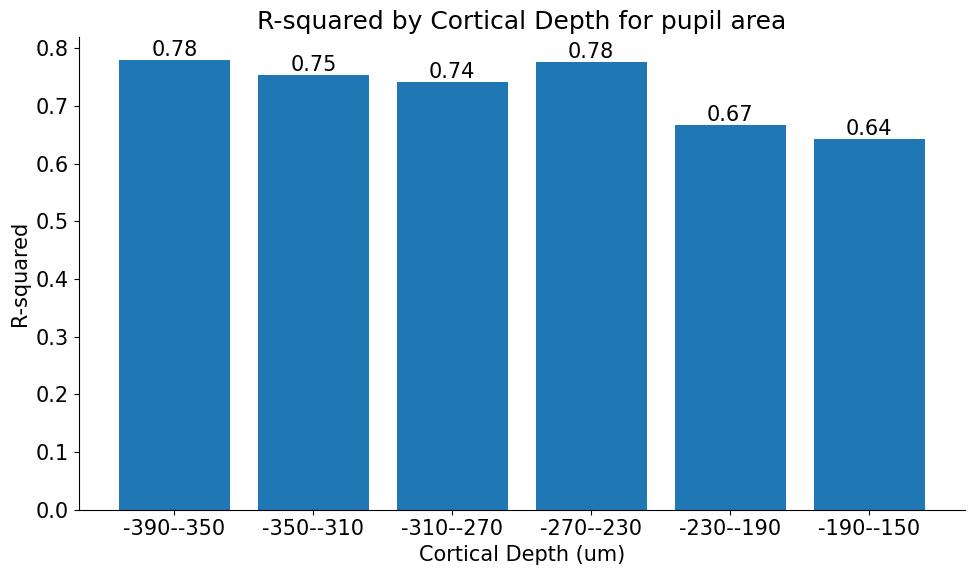

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define cortical depth bins (adjusted to range -390 to -150 mm)
depth_bins = [-390, -350, -310, -270, -230, -190, -150]  # Using six bins

# Extract the target variable
y = dat['pupilArea']

# List to store R² scores for each depth segment
depth_r2_scores = []

# Iterate over cortical depth bins
for i in range(len(depth_bins) - 1):
    print(f"Processing depth bin: {depth_bins[i]} - {depth_bins[i+1]}")

    # Segment neurons by depth
    depth_mask = (dat['xyz'][2, :] >= depth_bins[i]) & (dat['xyz'][2, :] < depth_bins[i + 1])
    X_depth = dat['sresp'][depth_mask, :].T  # Transpose to get timebins x neurons

    print(f"Number of neurons in this bin: {X_depth.shape[1]}")

    if X_depth.shape[1] == 0:
        depth_r2_scores.append(np.nan)
        continue  # Skip if no neurons fall into this depth bin

    # Standardize the neural response data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_depth)

    print(f"Shape after scaling: {X_scaled.shape}")

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Shape after PCA: {X_pca.shape}")

    # Filter y to match the timebins in X
    y_filtered = y[:X_pca.shape[0], :]  # Ensure y has the same number of samples as X

    print(f"Shape of filtered y: {y_filtered.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_filtered, test_size=0.3, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    depth_r2_scores.append(r2)
    print(f'Cortical Depth: {depth_bins[i]} - {depth_bins[i+1]}, R-squared: {r2:.2f}')

# Plot the R² scores for each depth segment
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(depth_r2_scores)), depth_r2_scores, tick_label=[f'{depth_bins[i]}-{depth_bins[i+1]}' for i in range(len(depth_bins) - 1)])

plt.xlabel('Cortical Depth (um)')
plt.ylabel('R-squared')
plt.title('R-squared by Cortical Depth for pupil area')

# Add the R² values on top of the bars
for bar, r2 in zip(bars, depth_r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{r2:.2f}', ha='center', va='bottom')

plt.show()


Processing depth bin: -390 - -350
Number of neurons in this bin: 2826
Shape after scaling: (7018, 2826)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -390 - -350, R-squared: 0.72
Processing depth bin: -350 - -310
Number of neurons in this bin: 1418
Shape after scaling: (7018, 1418)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -350 - -310, R-squared: 0.74
Processing depth bin: -310 - -270
Number of neurons in this bin: 1471
Shape after scaling: (7018, 1471)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -310 - -270, R-squared: 0.76
Processing depth bin: -270 - -230
Number of neurons in this bin: 2736
Shape after scaling: (7018, 2736)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Cortical Depth: -270 - -230, R-squared: 0.80
Processing depth bin: -230 - -190
Number of neurons in this bin: 1218
Shape after scaling: (7018, 1218)
Shape after PCA: (7018, 50)
Shape of filtered y: (7018, 1)
Corti

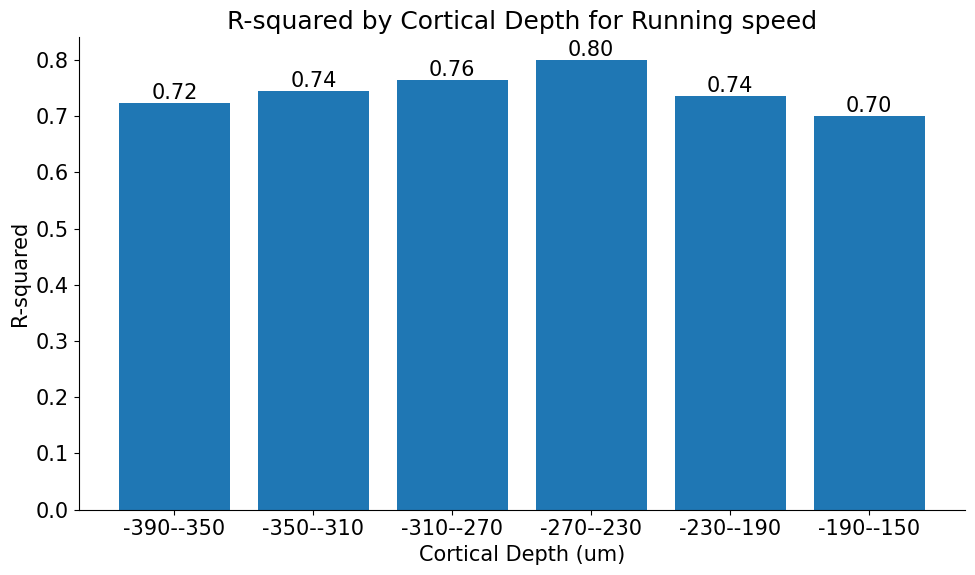

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define cortical depth bins (adjusted to range -390 to -150 mm)
depth_bins = [-390, -350, -310, -270, -230, -190, -150]  # Using six bins

# Extract the target variable
y = dat['run']

# List to store R² scores for each depth segment
depth_r2_scores = []

# Iterate over cortical depth bins
for i in range(len(depth_bins) - 1):
    print(f"Processing depth bin: {depth_bins[i]} - {depth_bins[i+1]}")

    # Segment neurons by depth
    depth_mask = (dat['xyz'][2, :] >= depth_bins[i]) & (dat['xyz'][2, :] < depth_bins[i + 1])
    X_depth = dat['sresp'][depth_mask, :].T  # Transpose to get timebins x neurons

    print(f"Number of neurons in this bin: {X_depth.shape[1]}")

    if X_depth.shape[1] == 0:
        depth_r2_scores.append(np.nan)
        continue  # Skip if no neurons fall into this depth bin

    # Standardize the neural response data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_depth)

    print(f"Shape after scaling: {X_scaled.shape}")

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Shape after PCA: {X_pca.shape}")

    # Filter y to match the timebins in X
    y_filtered = y[:X_pca.shape[0], :]  # Ensure y has the same number of samples as X

    print(f"Shape of filtered y: {y_filtered.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_filtered, test_size=0.3, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    depth_r2_scores.append(r2)
    print(f'Cortical Depth: {depth_bins[i]} - {depth_bins[i+1]}, R-squared: {r2:.2f}')

# Plot the R² scores for each depth segment
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(depth_r2_scores)), depth_r2_scores, tick_label=[f'{depth_bins[i]}-{depth_bins[i+1]}' for i in range(len(depth_bins) - 1)])

plt.xlabel('Cortical Depth (um)')
plt.ylabel('R-squared')
plt.title('R-squared by Cortical Depth for Running speed')

# Add the R² values on top of the bars
for bar, r2 in zip(bars, depth_r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{r2:.2f}', ha='center', va='bottom')

plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define cortical depth bins (adjusted to range -390 to -150 mm)
depth_bins = [-390, -350, -310, -270, -230, -190, -150]  # Six bins

# Extract the target variable
y = dat['pupilArea']

# Original R² score using all neurons
original_r2 = 0.88

# List to store R² scores after eliminating each depth segment
elimination_r2_scores = []

# Standardize the full neural response data for consistency in scaling
scaler = StandardScaler()

# Iterate over cortical depth bins
for i in range(len(depth_bins) - 1):
    print(f"Excluding depth bin: {depth_bins[i]} - {depth_bins[i+1]}")

    # Segment neurons to exclude the current depth bin
    exclude_mask = (dat['xyz'][2, :] < depth_bins[i]) | (dat['xyz'][2, :] >= depth_bins[i + 1])
    X_excluded = dat['sresp'][exclude_mask, :]  # Shape (neurons, timebins)

    print(f"Number of neurons excluded: {X_excluded.shape[0]}")

    if X_excluded.shape[0] == 0:
        elimination_r2_scores.append(np.nan)
        continue  # Skip if no neurons remain after exclusion

    # Standardize the neural response data for the remaining neurons
    X_excluded_scaled = scaler.fit_transform(X_excluded.T)  # Transpose to get (timebins, neurons)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_excluded_scaled, y, test_size=0.3, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    elimination_r2_scores.append(r2)
    print(f'Excluding Cortical Depth: {depth_bins[i]} - {depth_bins[i+1]}, R-squared: {r2:.2f}')

# Identify the layer whose removal reduces the R² score the most
r2_reduction = [original_r2 - r2 for r2 in elimination_r2_scores]
most_important_layer_idx = np.argmax(r2_reduction)
most_important_layer = f'{depth_bins[most_important_layer_idx]}-{depth_bins[most_important_layer_idx + 1]}'
print(f'The most important layer is: {most_important_layer} with an R² reduction of {r2_reduction[most_important_layer_idx]:.2f}')

# Plot the R² scores after eliminating each depth segment and print values on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(elimination_r2_scores)), elimination_r2_scores, tick_label=[f'{depth_bins[i]}-{depth_bins[i+1]}' for i in range(len(depth_bins) - 1)])
plt.xlabel('Cortical Depth (mm)')
plt.ylabel('R-squared')
plt.title('R-squared by Cortical Depth Elimination')

# Add the R² values on top of the bars
for bar, r2 in zip(bars, elimination_r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{r2:.2f}', ha='center', va='bottom')

plt.show()


Excluding depth bin: -390 - -350
Number of neurons excluded: 9157
Excluding Cortical Depth: -390 - -350, R-squared: 0.76
Excluding depth bin: -350 - -310
Number of neurons excluded: 10565
Excluding Cortical Depth: -350 - -310, R-squared: 0.80
Excluding depth bin: -310 - -270
Number of neurons excluded: 10512


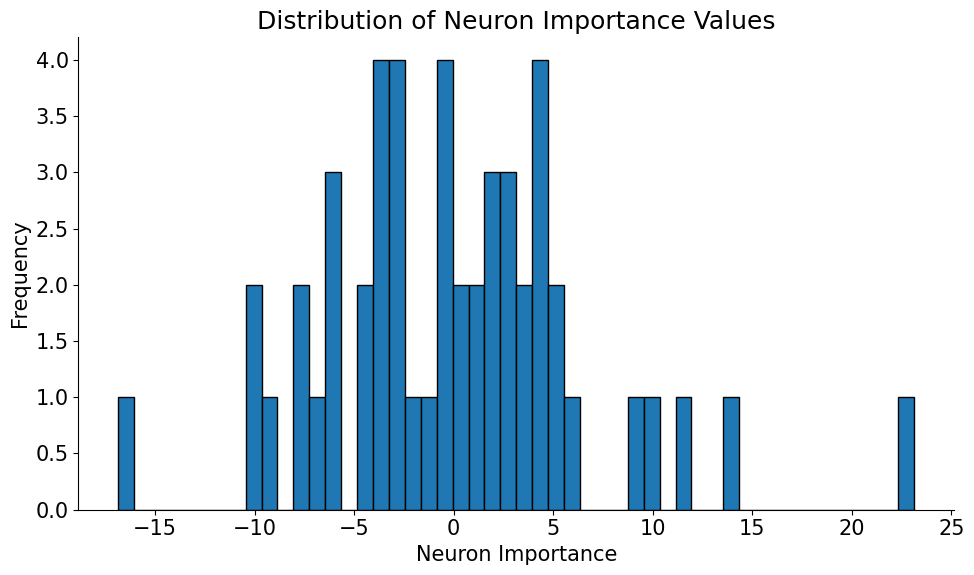

ValueError: 'c' argument has 50 elements, which is inconsistent with 'x' and 'y' with size 11983.

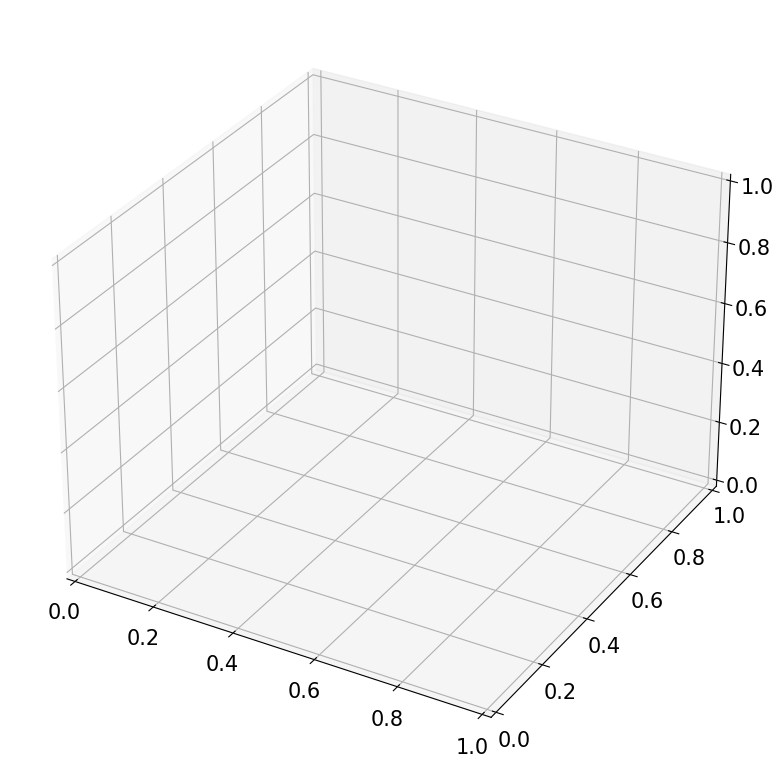

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Extract the neural response data and the target variable
X = dat['sresp'].T  # Transpose to get timebins x neurons
y = dat['pupilArea']
xyz = dat['xyz'].T  # Transpose to get neurons x 3

# Standardize the neural response data using z-scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Train a linear regression model
model = LinearRegression()
model.fit(X_pca, y)

# Get the coefficients from the linear regression model
coefficients = model.coef_[0]  # Assuming y is 1-dimensional

# Transform PCA components back to the original feature space to get neuron importance
pca_components = pca.components_.T
neuron_importance = coefficients

# Plot the distribution of neuron importance values
plt.figure(figsize=(10, 6))
plt.hist(neuron_importance, bins=50, edgecolor='black')
plt.title('Distribution of Neuron Importance Values')
plt.xlabel('Neuron Importance')
plt.ylabel('Frequency')
plt.show()

# Normalize the neuron importance for better visualization
norm_importance = (neuron_importance - neuron_importance.min()) / (neuron_importance.max() - neuron_importance.min())

# Plot the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons with color based on their importance
sc = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=norm_importance, cmap='coolwarm', s=20)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Neuron Importance')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Scatter Plot of Neuron Importance in Controlling Pupil Area')

plt.show()


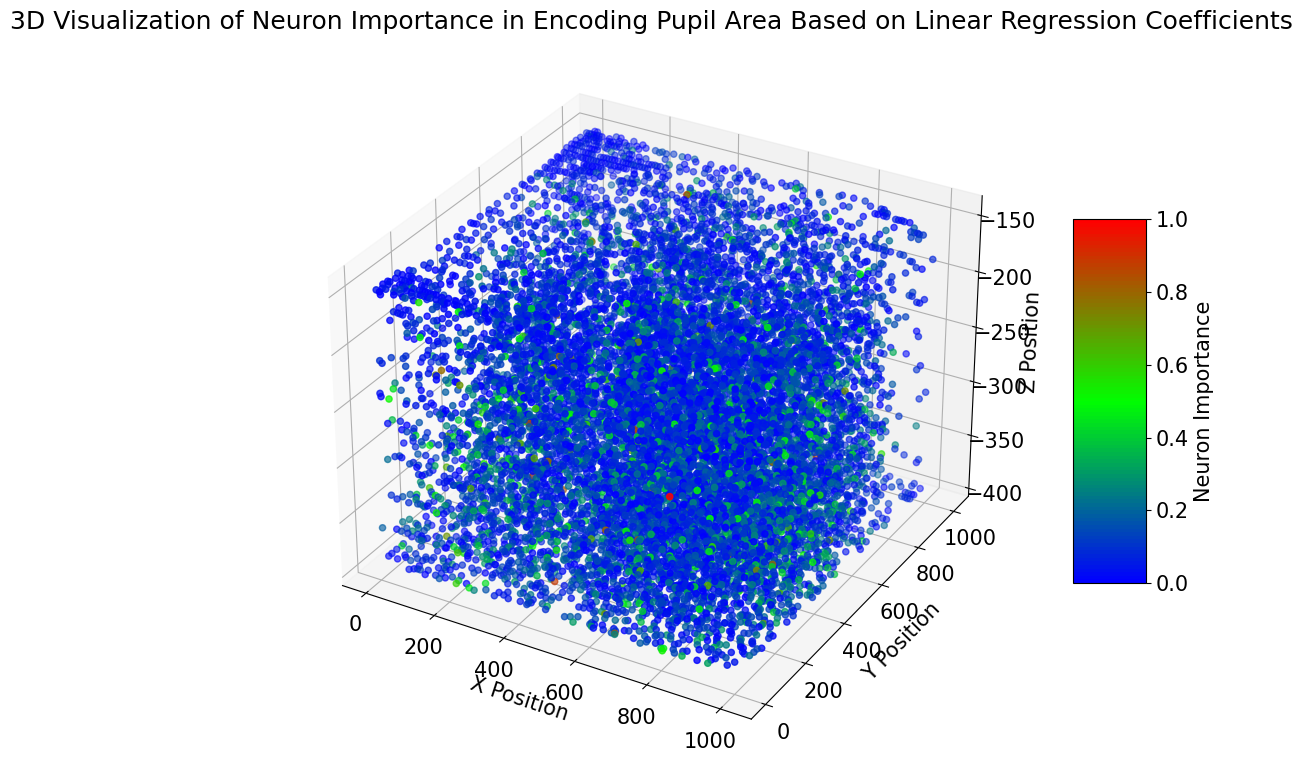

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Extract the neural response data and the target variable
X = dat['sresp'].T  # Transpose to get timebins x neurons
y = dat['pupilArea']
xyz = dat['xyz'].T  # Transpose to get neurons x 3

# Standardize the neural response data using z-scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Train a linear regression model
model = LinearRegression()
model.fit(X_pca, y)

# Get the coefficients from the linear regression model
coefficients = model.coef_[0]  # Assuming y is 1-dimensional

# Transform PCA components back to the original feature space to get neuron importance
pca_components = pca.components_.T
neuron_importance = np.abs(np.dot(pca.components_.T, coefficients))

# Normalize the neuron importance for better visualization
norm_importance = (neuron_importance - neuron_importance.min()) / (neuron_importance.max() - neuron_importance.min())

# Create a custom colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue -> Green -> Red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_blue_green_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons with color based on their importance
sc = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=norm_importance, cmap=cm, s=20)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Neuron Importance')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Visualization of Neuron Importance in Encoding Pupil Area Based on Linear Regression Coefficients')

plt.show()


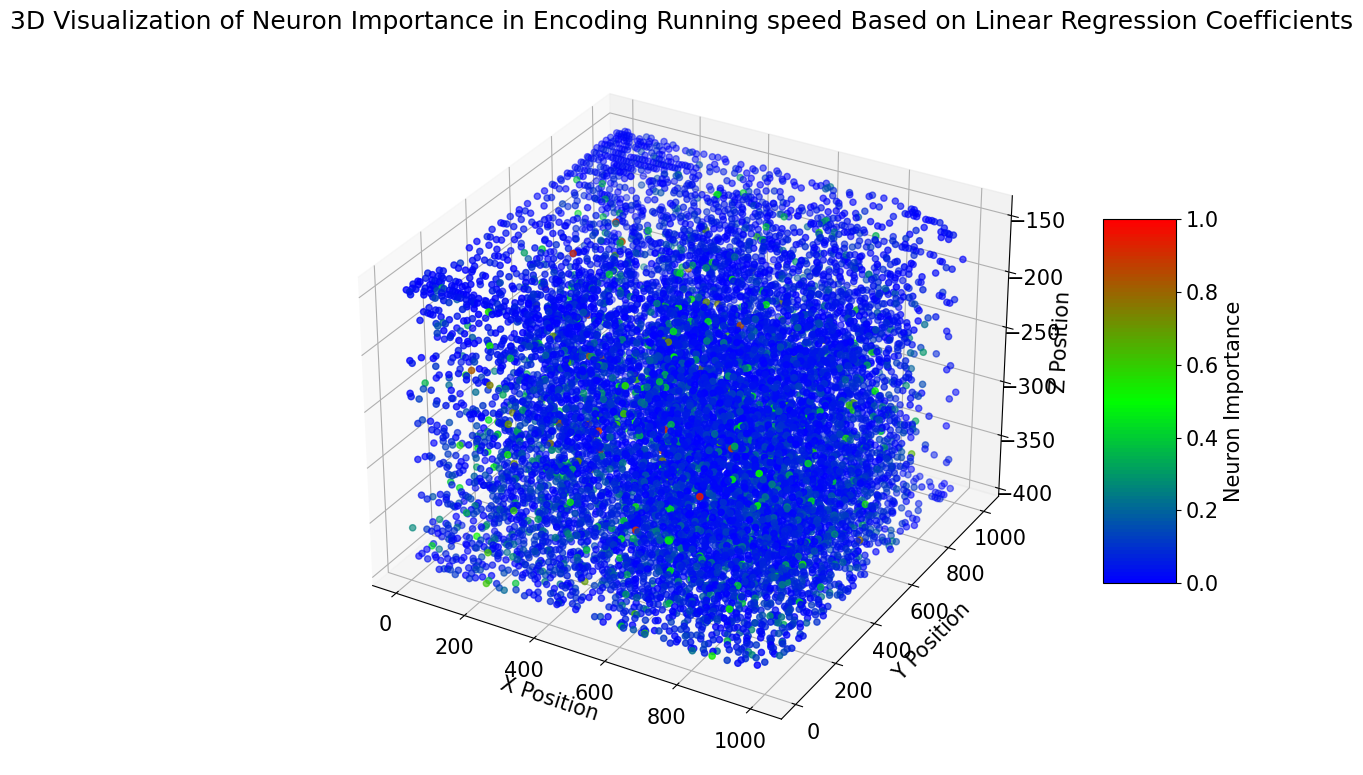

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Extract the neural response data and the target variable
X = dat['sresp'].T  # Transpose to get timebins x neurons
y = dat['run']
xyz = dat['xyz'].T  # Transpose to get neurons x 3

# Standardize the neural response data using z-scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Train a linear regression model
model = LinearRegression()
model.fit(X_pca, y)

# Get the coefficients from the linear regression model
coefficients = model.coef_[0]  # Assuming y is 1-dimensional

# Transform PCA components back to the original feature space to get neuron importance
pca_components = pca.components_.T
neuron_importance = np.abs(np.dot(pca.components_.T, coefficients))

# Normalize the neuron importance for better visualization
norm_importance = (neuron_importance - neuron_importance.min()) / (neuron_importance.max() - neuron_importance.min())

# Create a custom colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue -> Green -> Red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_blue_green_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons with color based on their importance
sc = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=norm_importance, cmap=cm, s=20)

# Add color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Neuron Importance')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Visualization of Neuron Importance in Encoding Running speed Based on Linear Regression Coefficients')

plt.show()
